In [19]:
import os 
import sys 
#3.9.6
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if project_root not in sys.path: 
    sys.path.insert(0, project_root)

from data.TrajectorySet import TrajectorySet
from data.Sampler import Sampler  

from models.cmhn import cmhn 
from models.cl_model import mlpCL

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import minari

In [2]:
PROJECT_ROOT = project_root
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu" 

# Load cmhn model 
cmhn = cmhn(update_steps=1, device=DEVICE)

# Load trained CL model 
model_name = "best_model_laplace_15.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    cl_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))
else:
    print("No model found.")



Found pretrained model at /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL/best_models/best_model_laplace_15.ckpt, loading...


In [3]:
# Sample states near each other 
T = TrajectorySet(dataset=MINARI_DATASET)
S = Sampler(T, dist="l", b=5)

state_info = S.sample_states(3)

d = {
    "state": [], 
    "trajectory_idx": []
}



In [4]:
print(state_info)
for tuple in state_info: 
    d["state"].append(tuple[0])
    d["trajectory_idx"].append(tuple[1])
d

[([array([ 0.54118302, -1.23111934,  2.24302087, -0.70543772]), 245], 3246), ([array([-1.73144532,  0.82480622, -4.28491818, -0.57437038]), 244], 2730), ([array([ 0.28291722, -1.69108166,  1.45223006, -4.87409801]), 152], 2150)]


{'state': [[array([ 0.54118302, -1.23111934,  2.24302087, -0.70543772]), 245],
  [array([-1.73144532,  0.82480622, -4.28491818, -0.57437038]), 244],
  [array([ 0.28291722, -1.69108166,  1.45223006, -4.87409801]), 152]],
 'trajectory_idx': [3246, 2730, 2150]}

In [5]:
# Sample nearby neighbours
num_neighbours = 5

neighbours = []
for i in range(len(d["trajectory_idx"])): 
    state_neighbour = []
    for j in range(num_neighbours): 
        t_idx = d["trajectory_idx"][i] 
        s = d["state"][i]
        state_neighbour.append(S.sample_positive_pair(t_idx, s)[0])
    neighbours.append(state_neighbour)

neighbours

[[array([ 0.65413065, -1.23712061,  3.17098627,  0.1650631 ]),
  array([ 0.80397642, -1.21085621,  4.09014288,  0.79996564]),
  array([ 0.62242079, -1.23877124,  2.93982402, -0.07327526]),
  array([ 0.59302255, -1.23803849,  2.70810992, -0.22632106]),
  array([ 0.49865638, -1.21460642,  1.77570853, -1.18684472])],
 [array([-1.87204935,  0.80572312, -4.80723328, -0.58253623]),
  array([-1.97236707,  0.79220698, -4.99782399, -0.6312928 ]),
  array([-1.68859614,  0.83054993, -4.05641526, -0.77954511]),
  array([-1.87204935,  0.80572312, -4.80723328, -0.58253623]),
  array([-1.64803198,  0.83834538, -3.82736682, -0.6258493 ])],
 [array([ 0.31695709, -1.78572458,  1.81918831, -4.72239651]),
  array([ 0.25622527, -1.59587066,  0.98113747, -4.41936314]),
  array([ 0.2464139 , -1.55167703,  0.74474735, -4.19118117]),
  array([ 0.29876521, -1.73850061,  1.58479888, -4.74189542]),
  array([ 0.25622527, -1.59587066,  0.98113747, -4.41936314])]]

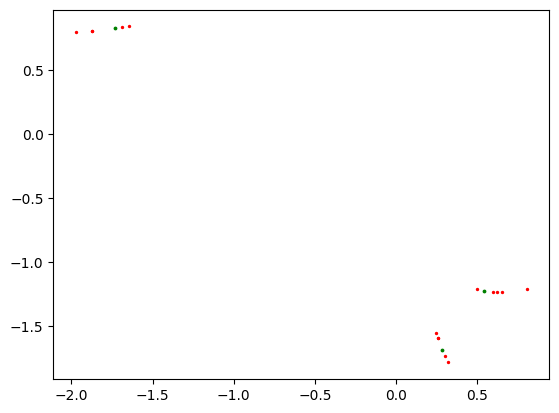

In [6]:
plt.plot(figsize=(10,5))
for i in range(len(d["state"])): 
    plt.scatter(x=d["state"][i][0][0], y=d["state"][i][0][1], s=3, c="green")
    for j in range(num_neighbours): 
        plt.scatter(x=neighbours[i][j][0], y = neighbours[i][j][1], s=2, c="red")

plt.show()

In [11]:
states = [] 

for i in range(len(d["state"])): 
    states.append(d["state"][i][0])
    for j in range(num_neighbours): 
        states.append(neighbours[i][j])
tensor_states = torch.as_tensor(states, dtype=torch.float32)

In [ ]:
# Project into high dimensional space 
with torch.no_grad(): 
    z = cl_model(tensor_states)

In [18]:
beta = torch.as_tensor(35, dtype=torch.float32)

# mhn clusters 
U = cmhn.run(z, z, beta=beta, run_as_batch=True)

U.size() 

torch.Size([18, 32])

In [25]:
pca = PCA(n_components=2) 

points = pca.fit_transform(U)
points

array([[-16.7655862 ,  -3.46756431],
       [-16.94244331,  -3.25421548],
       [-16.40782957,  -1.96737332],
       [-17.46333775,  -3.42427899],
       [-17.46333775,  -3.42427899],
       [-16.98058474,  -3.24609675],
       [ 12.00062485, -11.03540794],
       [ 12.54065796, -11.36132262],
       [ 12.54065796, -11.36132262],
       [ 12.00062485, -11.03540794],
       [ 12.54065796, -11.36132262],
       [  8.42373337,  -9.46581729],
       [  5.97287489,  14.43616374],
       [  5.52659816,  13.84593774],
       [  5.67741681,  14.52939824],
       [  3.59525755,  13.21757318],
       [  5.52659816,  13.84593774],
       [  5.67741681,  14.52939824]])

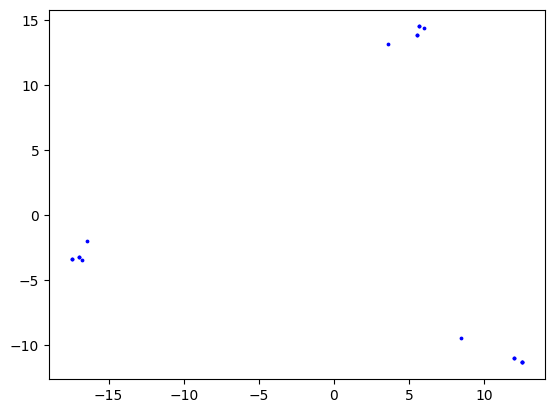

In [28]:
plt.plot(figsize=(10,6))
for i in range(len(points)): 
    plt.scatter(x=points[i][0], y= points[i][1], s=3, c= "blue")

plt.show()